In [27]:
import torch 
import torchsummary
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
train_path = "train"
valid_path = "valid"
import plotly.express as px
from IPython.display import display, clear_output


### Creating a neural net

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = torch.nn.Sequential(
    torch.nn.Conv2d(3,6,5),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(6,16,5),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Flatten(),
    torch.nn.Linear(16*5*5,120),
    torch.nn.ReLU(),
    torch.nn.Linear(120,84),
    torch.nn.ReLU(),
    torch.nn.Linear(84,10),
    torch.nn.Softmax(dim=1)
).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)



### Getting to know our model

In [29]:
print(torchsummary.summary(net, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
              ReLU-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              ReLU-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
          Softmax-11                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [30]:
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=transforms.ToTensor())
valid_path = torchvision.datasets.ImageFolder(root=valid_path, transform=transforms.ToTensor())

In [35]:
bs = 64
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_path, batch_size=bs, shuffle=True)

Epoch: 1 | Training Loss: 112.8211 | Validation Loss: 114.3029
Epoch: 2 | Training Loss: 112.5512 | Validation Loss: 114.0730
Epoch: 3 | Training Loss: 112.3033 | Validation Loss: 114.2177
Epoch: 4 | Training Loss: 111.9609 | Validation Loss: 113.5654
Epoch: 5 | Training Loss: 111.9229 | Validation Loss: 113.9882
Epoch: 6 | Training Loss: 111.9977 | Validation Loss: 113.6854
Epoch: 7 | Training Loss: 111.7412 | Validation Loss: 114.3921
Epoch: 8 | Training Loss: 112.0037 | Validation Loss: 112.9765
Epoch: 9 | Training Loss: 111.1979 | Validation Loss: 113.2097
Epoch: 10 | Training Loss: 111.1876 | Validation Loss: 113.4392
Epoch: 11 | Training Loss: 111.2142 | Validation Loss: 113.3980
Epoch: 12 | Training Loss: 111.4122 | Validation Loss: 113.6742
Epoch: 13 | Training Loss: 111.2765 | Validation Loss: 113.9850
Epoch: 14 | Training Loss: 111.1841 | Validation Loss: 113.5350
Epoch: 15 | Training Loss: 111.2233 | Validation Loss: 114.0827
Epoch: 16 | Training Loss: 110.8972 | Validation 

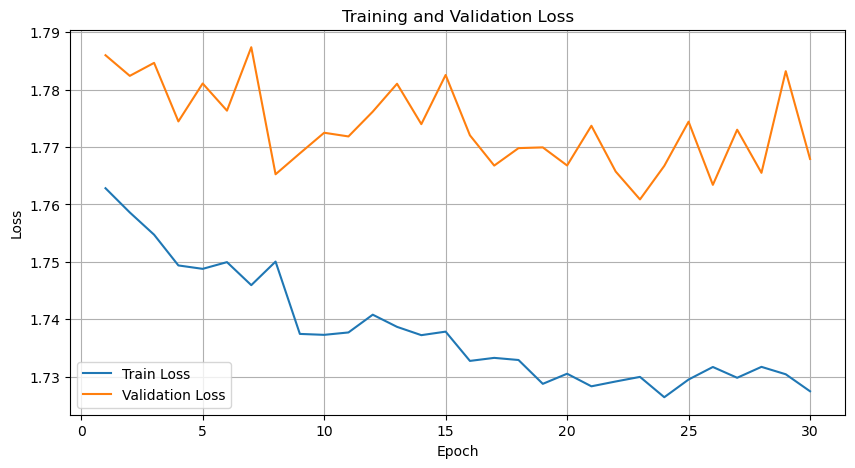

In [39]:

import matplotlib.pyplot as plt

train_losses = []  # List to store training losses for each epoch
valid_losses = []  # List to store validation losses for each epoch
epochs = 50
# Assuming you have a loop that runs for each epoch
for epoch in range(epochs):
    train_loss_sum = 0.0
    valid_loss_sum = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    
    net.eval()
    with torch.inference_mode():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = loss_fn(output, labels)
            valid_loss_sum += loss.item()
    # Calculate the average loss for the entire epoch
    avg_train_loss = train_loss_sum / len(train_loader)
    avg_valid_loss = valid_loss_sum / len(valid_loader)
    print(f"Epoch: {epoch+1} | Training Loss: {avg_train_loss*bs:.4f} | Validation Loss: {avg_valid_loss*bs:.4f}")
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



In [40]:
torch.save(net.state_dict(), "model.pth")

In [64]:
import torchvision, torch
from torchvision import datasets, models, transforms

def load_testing(root_path, dir, batch_size):

    data = datasets.ImageFolder(root=root_path + dir, transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

    return loader



FileNotFoundError: [WinError 3] The system cannot find the path specified: '.test'